In [377]:
import numpy as np
import pandas as pd
import altair as alt
import copy

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server");

In [266]:
stinson2019 = pd.read_pickle("../data/stinson2019/stinson2019_df")
HF_weather = pd.read_csv('../data/HF_weather/raw/hf001-08-hourly-m.csv', parse_dates=['datetime'])

/home/steffen/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,5,7,9,11,13,15,17,19,21,23,25,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [267]:
stinson2019 = stinson2019.sort_values(["site", "tree", "tap", "date"])

# Create unique record ids for each entry
stinson2019["record_id"] = (
    + stinson2019["tree"]
    + "_"
    + stinson2019["tap"]
    + "_"
    + pd.DatetimeIndex(stinson2019["year"]).year.astype(str)
    + "_"
)

for tapyear in stinson2019["record_id"].unique():
    stinson2019.loc[stinson2019["record_id"] == tapyear, "record_id"] += [
        str(i)
        for i in range(stinson2019[stinson2019["record_id"] == tapyear].shape[0])
    ]
    
stinson2019['tap_id'] = stinson2019['tree']+stinson2019['tap']


# normalize data tables
tap_records = stinson2019[['record_id', 'tap_id']].set_index('record_id')
sap = stinson2019[['record_id', 'sap_wt']].rename(columns={"sap_wt": "sap"}).set_index('record_id')
sugar = stinson2019[['record_id', 'sugar']].set_index('record_id')
dates = stinson2019[['record_id', 'date']].set_index('record_id')
dates.loc[:,'date'] = pd.to_datetime(dates['date'])
tap_tree = stinson2019[['tap_id','tree']].drop_duplicates().set_index('tap_id')
species = stinson2019[['tree','species']].drop_duplicates().set_index('tree')
site = stinson2019[['tree','site']].drop_duplicates().set_index('tree')
site['site'] = site['site'].str.upper()

In [416]:
stinson2019

,site,date,tree,species,tap,sugar,sap_wt,year,site_id,tree_id,tree_record_id,tap_record_id,record_id,tap_id
5299,Dartmouth Organic Farm,2014-03-11,DOF1,ACSA,A,1.2,0.03,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-11,DOF.ACSA.DOF1.A.2014-03-11,DOF1_A_2014_0,DOF1A
5322,Dartmouth Organic Farm,2014-03-17,DOF1,ACSA,A,NaN,0.01,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-17,DOF.ACSA.DOF1.A.2014-03-17,DOF1_A_2014_1,DOF1A
5345,Dartmouth Organic Farm,2014-03-30,DOF1,ACSA,A,NaN,NaN,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-30,DOF.ACSA.DOF1.A.2014-03-30,DOF1_A_2014_2,DOF1A
5368,Dartmouth Organic Farm,2014-03-31,DOF1,ACSA,A,NaN,0.01,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-31,DOF.ACSA.DOF1.A.2014-03-31,DOF1_A_2014_3,DOF1A
5391,Dartmouth Organic Farm,2014-04-01,DOF1,ACSA,A,2.2,0.67,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-04-01,DOF.ACSA.DOF1.A.2014-04-01,DOF1_A_2014_4,DOF1A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,Southernmost Maple,2016-02-28,SMAS8,ACSA,B,2.1,15.11,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-02-28,SMM.ACSA.SMAS8.B.2016-02-28,SMAS8_B_2016_3,SMAS8B
7817,Southernmost Maple,2016-02-29,SMAS8,ACSA,B,1.8,9.11,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-02-29,SMM.ACSA.SMAS8.B.2016-02-29,SMAS8_B_2016_4,SMAS8B
7849,Southernmost Maple,2016-03-02,SMAS8,ACSA,B,2.4,10.41,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-03-02,SMM.ACSA.SMAS8.B.2016-03-02,SMAS8_B_2016_5,SMAS8B
7881,Southernmost Maple,2016-03-06,SMAS8,ACSA,B,1.8,17.01,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-03-06,SMM.ACSA.SMAS8.B.2016-03-06,SMAS8_B_2016_6,SMAS8B


In [413]:
a = get_weekly_data()
a

tap:   DOF1A
tap:   DOF1B
tap:   DOF10A
tap:   DOF10B
tap:   DOF11A
tap:   DOF12A
tap:   DOF13A
tap:   DOF14A
tap:   DOF15A
tap:   DOF15B
tap:   DOF16A
tap:   DOF16B
tap:   DOF17A
tap:   DOF17B
tap:   DOF18A
tap:   DOF19A
tap:   DOF2A
tap:   DOF2B
tap:   DOF20A
tap:   DOF21A
tap:   DOF21B
tap:   DOF22A
tap:   DOF23A
tap:   DOF24A
tap:   DOF25A
tap:   DOF26A
tap:   DOF27A
tap:   DOF3A
tap:   DOF3B
tap:   DOF4A
tap:   DOF5A
tap:   DOF6A
tap:   DOF7A
tap:   DOF8A
tap:   DOF9A
tap:   DOF9B
tap:   RM 24A
tap:   RM1A
tap:   RM10A
tap:   RM11A
tap:   RM12A
tap:   RM13A
tap:   RM13B
tap:   RM14A
tap:   RM15A
tap:   RM16A
tap:   RM17A
tap:   RM17B
tap:   RM18A
tap:   RM18B
tap:   RM19A
tap:   RM2A
tap:   RM2B
tap:   RM20A
tap:   RM21A
tap:   RM21B
tap:   RM22A
tap:   RM23A
tap:   RM24A
tap:   RM25A
tap:   RM26A
tap:   RM3A
tap:   RM4A
tap:   RM5A
tap:   RM6A
tap:   RM7A
tap:   RM8A
tap:   RM9A
tap:   RM9B
tap:   SG1A
tap:   SG10A
tap:   SG11A
tap:   SG12A
tap:   SG13A
tap:   SG14A
tap:   SG15A


,record_id,tap_id,tree,sap,sugar,date,year,jd,sugarwt,cum_sap,cum_sugarwt,weekly_sap,weekly_sugarwt
date,,,,,,,,,,,,,
2014-03-11,DOF1_A_2014_0,DOF1A,DOF1,0.03,1.2,2014-03-11,2014.0,70.0,0.036,0.03,0.036,NaN,NaN
2014-03-12,NaN,NaN,NaN,NaN,NaN,2014-03-12,NaN,NaN,NaN,0.03,0.036,NaN,NaN
2014-03-13,NaN,NaN,NaN,NaN,NaN,2014-03-13,NaN,NaN,NaN,0.03,0.036,NaN,NaN
2014-03-14,NaN,NaN,NaN,NaN,NaN,2014-03-14,NaN,NaN,NaN,0.03,0.036,NaN,NaN
2014-03-15,NaN,NaN,NaN,NaN,NaN,2014-03-15,NaN,NaN,NaN,0.03,0.036,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-04,NaN,NaN,NaN,NaN,NaN,2016-03-04,NaN,NaN,NaN,51.95,109.487,34.63,73.113
2016-03-05,NaN,NaN,NaN,NaN,NaN,2016-03-05,NaN,NaN,NaN,51.95,109.487,34.63,73.113
2016-03-06,SMAS8_B_2016_6,SMAS8B,SMAS8,17.01,1.8,2016-03-06,2016.0,66.0,30.618,68.96,140.105,36.53,72.000


In [412]:
def get_weekly_data(location = ['all'], tree= 'all',tap_id='all',years='all'):
    """Generate data table containing cumulative weekly sap and sugar amounts

    Parameters
    ----------
    location : str or list of str, optional
        [description], by default 'all'
    tree : str or list of str, optional
        [description], by default 'all'
    tap_id : str or list of str, optional
        [description], by default 'all'
    years : int, list of ints, or 'all' , optional
        [description], by default 'all'

    Returns
    -------
    [type]
        [description]
    """
    # Check and clean location argument
    if type(location) != list:
        location = [location]
    location = [x.upper() for x in location]
    if location == ['ALL']:
        location = site['site'].unique().tolist()

    # Check and clean tap_id argument
    if type(tap_id) != list:
        tap_id = [tap_id]
    tap_id= [x.upper() for x in tap_id]
    if tap_id == ['ALL']:
        tap_id = tap_tree.index.tolist()
    
    # Check and clean tree argument
    if type(tree) != list:
        tree = [tree]
    tree = [x.upper() for x in tree]
    if tree == ['ALL']:
        tree = tap_tree['tree'].unique().tolist()
    
    # Check and clean years argument
    if type(years) != list:
        years = [years]
    if type(years[0]) == str:
        years[0] = years[0].upper()
        if years == ['ALL']:
            years = pd.DatetimeIndex(dates['date']).year.unique().tolist()
    
    tap_id = tap_tree[tap_tree.index.isin(tap_id)].join(site, how= 'left', on='tree')
    tap_id = tap_id[(tap_id['tree'].isin(tree)) & (tap_id['site'].isin(location))].index.tolist()

    weekly_df = pd.DataFrame()
    
    for tap in tap_id:
        print('tap:  ', tap)
        df = (
            tap_records.join(tap_tree[tap_tree.index==tap], how="right", on="tap_id")
            .join(sap, how="left")
            .join(sugar, how="left")
            .join(dates[pd.DatetimeIndex(dates["date"]).year.isin(years)], how="inner")
        )
        df["year"] = pd.DatetimeIndex(df["date"]).year
        df["jd"] = pd.DatetimeIndex(df["date"]).dayofyear

        for year in df['year'].unique():
#             print('     year: ', year)
            df_year = df[df['year']==year]

            # Deal with multiple entries per day.  Sap taken as sum of measurements, sugar content as weighted average.
            if not df_year['jd'].is_unique:
                df_year_temp = copy.copy(df_year)
                df_year_temp['product'] = df_year_temp.sap*df_year_temp.sugar.fillna(value = df_year_temp.sugar.mean())
                df_year_temp = df_year_temp.groupby(by='jd').sum().reset_index()
                df_year_temp['sugar'] = df_year_temp['product']/df_year_temp['sap']
                df_year = df_year.drop_duplicates(subset='jd')
                df_year = df_year.reset_index().merge(df_year_temp[['jd','sap','sugar']], on = 'jd', how='right', suffixes = ['', '_sum']).set_index('record_id')
                df_year['sap'] = df_year['sap_sum']
                df_year['sugar'] = df_year['sugar_sum']
                df_year = df_year.drop(columns = ['sap_sum', 'sugar_sum'])

            df_year = df_year.reset_index().merge(
                pd.date_range(start=df_year["date"].min(), end=df_year["date"].max()).to_frame(name='date'),
                how="right",
                on='date',
            ).set_index('date', drop=False)
            
            # Assumption: missing sugar content should be filled with mean sugar content
            df_year['sugarwt'] = df_year.sap*df_year.sugar.fillna(value = df_year.sugar.mean())

            # Assumptio
186

In [5]: a.reset_index().merge(b, how="left").set_index('index')n: missing sap values should be replaced with zeros
            df_year["cum_sap"] = df_year.sap.fillna(value=0).cumsum()
            df_year["cum_sugarwt"] = df_year.sugarwt.fillna(value=0).cumsum()

            for day in df_year.index[6:]:
                if df_year['date'].min() == (day - pd.to_timedelta(6, unit='D')):
                    df_year.loc[day,'weekly_sap'] = df_year.loc[day]['cum_sap']
                    df_year.loc[day,'weekly_sugarwt'] = df_year.loc[day]['cum_sugarwt']
                else:
                    df_year.loc[day,'weekly_sap'] = df_year.loc[day]['cum_sap'] - df_year.loc[day - pd.to_timedelta(7, unit='D')]['cum_sap']
                    df_year.loc[day,'weekly_sugarwt'] = df_year.loc[day]['cum_sugarwt'] - df_year.loc[day - pd.to_timedelta(7, unit='D')]['cum_sugarwt']
            
            weekly_df = weekly_df.append(df_year)
    
    return weekly_df

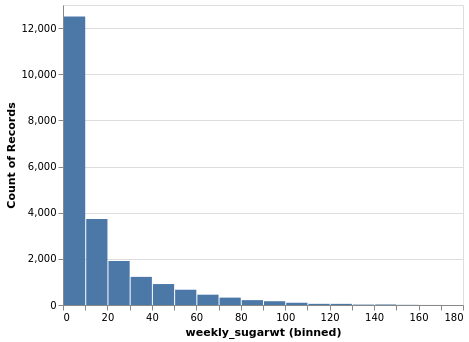

In [414]:
alt.Chart(a).mark_bar().encode(
    alt.X('weekly_sugarwt',bin=alt.Bin(maxbins=30)),
    alt.Y('count()')
)